# QAOA QUTIP

For the Energy: 

$E(s_0, s_1, s_2) = - s_0 + \frac{1}{2} s_1 - \frac{1}{2} s_2 + \frac{1}{2} s_0 s_1 + \frac{1}{2} s_1 s_2$

Where the Cost Hamiltonian is written as 

$H_c = \frac{1}{2} z_0 z_1 + \frac{1}{2} z_1 z_2 - z_0 + \frac{1}{2} z_1 - \frac{1}{2} z_2$

# e) The variational state

In the first part I create some functions necessaries for the matrices operations and also some of the matrices (gates) that I will need for the QAOA.


In [46]:
import numpy as np
import qutip as qtp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qutip.qip.operations import cnot, hadamard_transform, ry, rx, rz
from qutip.qip.circuit import QubitCircuit


# some functions for the operation of the matrices in qutip
def tensor_trip(A,B,C):                           # O_1 x O_2 x O_3 tensor product of 3 elements
    return qtp.tensor(qtp.tensor(A,B),C)
def resize(x,n: int):
    new_dims = [[n], [n]]    
    return qtp.Qobj(x, dims=new_dims)

nqubits: int = 3                                
p: int = 2                                            # p of the QAOA 
                                              #that I am using
hi = [-1, 0.5, -0.5] 
Jij = 0.5

# ----- Cost Hamiltonian ---------
HS = 2**nqubits                                         # hilbert space
iden = qtp.identity(2)                                  # identity 2x2
sigz = qtp.sigmaz()                                     # pauli_z
qubit = qtp.basis(2,0)                                  # |0>
q2 = qtp.basis(2,1)
Hada = hadamard_transform(1)                        # Hadamard matrix
CN = cnot(2)                                        #cnot
cn12 = qtp.tensor(CN, iden)                         #cnot 1->2
cn23 = qtp.tensor(iden, CN)                         #cnot 2->3
zzz = tensor_trip(qubit, q2, qubit)                 # |z_0z_1z_2> |010>


Ising Hamiltonian

In [22]:
def costha():                                       #cost hamltonian
    H1 = -1*tensor_trip(sigz,iden,iden)                   # - z_0
    H2 = 0.5*tensor_trip(iden, sigz,iden)                 # 1/2 z_1
    H3 = -0.5*tensor_trip(iden, iden, sigz)               # - 1/2 z_2
    H4 = 0.5*tensor_trip(sigz, sigz, iden)                # 1/2 z_0 z_1
    H5 = 0.5*tensor_trip(iden, sigz, sigz)                # 1/2 z_1 z_2
    Hf = H1 + H2 + H3 + H4 + H5
    Hf = resize(Hf, HS)
    return Hf

Hamil = costha()

print(Hamil)
# print(Hada)
print(qubit)

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -3.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.]]
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]


Creating the circuit, a general circuit for any p. We start in |000> and then the final state is |gamma, beta> 

In [23]:

def circ(gamma, beta):
    
    initial = tensor_trip(qubit, qubit, qubit)                  # |000>
    Hada3 = tensor_trip(Hada, Hada, Hada)   
    state = Hada3*initial                                       # |+++>                     
    
    #put the loop of p 
    for k in range(p):
        rzsingle = []
        rxbet    = []
        for i in range(nqubits):                
            rzsingle.append(rz(2*gamma[k]*hi[i]))               #creating rz(2*gamma_p*h_i)
            rxbet.append(rx(2*beta[k]))                         #creating rx(2*beta_p) 
            
        rzg3 = tensor_trip(rzsingle[0],rzsingle[1],rzsingle[2])     
        rxb3 = tensor_trip(rxbet[0], rxbet[1], rxbet[2])
        rzz12 = tensor_trip(iden, rz(2*gamma[k]*Jij), iden)
        rzz23 = tensor_trip(iden, iden, rz(2*gamma[k]*Jij)) 
        # state = rzg3*state
        state = cn12*state                                   #just applying the gates (matrices)
        state = rzz12*state 
        state = cn12*state
        state = cn23*state
        state = rzz23*state 
        state = cn23*state
        state = rzg3*state
        state = rxb3*state 
    
    final = qtp.Qobj(state, dims=[[HS], [1]] )
    return final


Creating the function to return the expectation value $<\gamma, \beta| H_C |\gamma, \beta> $

In [24]:
def f_expectation(param):                       # return the expectation value 
    gamma = param[:p]
    beta = param[p:]
    psi = circ(gamma,beta)
    return qtp.expect(Hamil, psi)

Calculating the values of the 2d plot of the expectation value. Just running with 2 for loops and saving the information of the expecation value in a matrix

In [25]:
if p==1:
    # initial value for gamma and beta
    beta = np.random.rand(p)*np.pi
    gamma = np.random.rand(p)*2*np.pi

    gamma_range = np.linspace(0, 2*np.pi,100)       #taking 150 values of gamma and beta
    beta_range = np.linspace(0, np.pi,100)          #can be longer, but that requires 
                                                    #more time and more computational power
                                                    #for example if a run 1000 my kernel crash
    Z = np.zeros((len(gamma_range), len(beta_range)))  

    for i, x in enumerate(gamma_range):
        # print(x)
        for j, y in enumerate(beta_range):
            l = [x,y]
            Z[i, j] = f_expectation(l)      #saving the values in a matrix

Plotting the 2D plot of the expected value with respect $\gamma$ and $\beta$ 

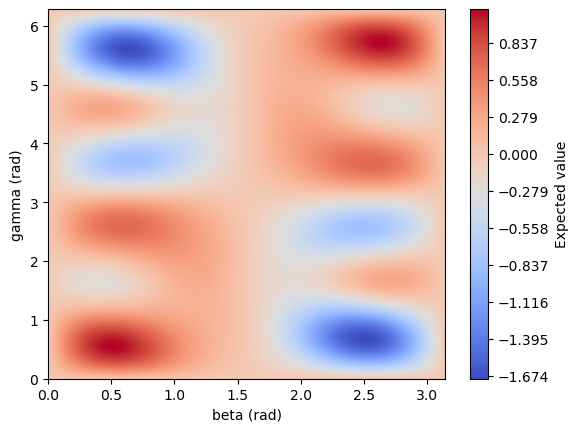

In [26]:
if p==1:
    # Create a filled contour plot with a color bar
    plt.contourf( beta_range,gamma_range, Z, cmap='coolwarm', levels=1000)
    plt.colorbar(label='Expected value')

    # Add labels 
    plt.xlabel('beta (rad)')
    plt.ylabel('gamma (rad)')

    plt.show()

We can see that the plot has 2 minimum regions, we are goint to obtain those values later.

The same plot but with some contour lines, just to visualize

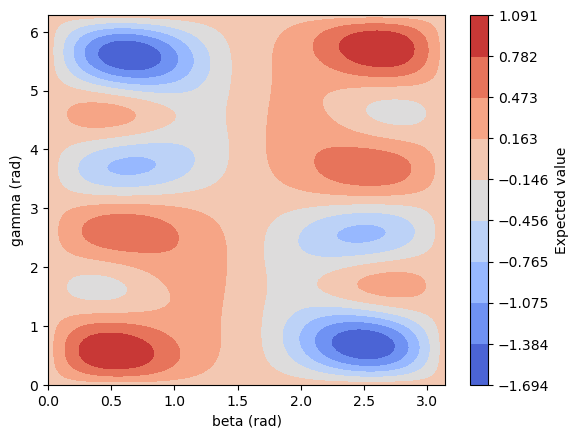

In [27]:
if p==1:
    # Set contour levels
    contour_levels = np.linspace(np.min(Z), np.max(Z), 10)
    X = gamma_range
    Y = beta_range

    # Create a filled contour plot with a color bar
    contour = plt.contourf(Y, X, Z, levels=contour_levels, cmap='coolwarm')
    plt.colorbar(contour, label='Expected value')

    # Add contour lines
    # contour_lines = plt.contour(Y, X, Z, levels=contour_levels, colors='black',
                                # linewidths=0.2, linestyles='solid')

    plt.xlabel('beta (rad)')
    plt.ylabel('gamma (rad)')

    # plt.scatter([0.6981317007977318], [0.6346651825433925], color='black')


    
    plt.show()

Obtaining the minimum value of the matrix Z (expected values) with numpy minimum, this function only return one value, but we know that they are 2 minimums. So, we have to search with a treshold.

In [28]:
if p==1:
    # Find the minimum value of Z and its indices
    min_value = np.min(Z)
    min_indices = np.unravel_index(np.argmin(Z), Z.shape)
    print(min_indices)

    # Extract the corresponding values
    min_x = gamma_range[min_indices[0]]
    min_y = beta_range[min_indices[1]]

    # Print the minimum value and corresponding values gamma and beta
    print("Minimum value of Z:", min_value)
    print("Corresponding values of gamma and beta:", min_x, min_y)

(11, 79)
Minimum value of Z: -1.6935462692791046
Corresponding values of gamma and beta: 0.6981317007977318 2.5069274710464007


Searching for the 2 minimum values with a treshold, and the extracting the values of $\gamma$ and $\beta$

In [29]:
if p==1:
    # Find all points where Z is less than a treshold 
    g_p1 = []
    b_p1 = []
    threshold = -1.69
    # minima_indices = np.where(Z < threshold)
    Z_val = Z
    indices1 = Z_val[Z_val< threshold]
    gam_bet = np.nonzero(Z_val<threshold)
    print(indices1)
    print(gam_bet)

    for i in range(len(indices1)):      # searching the gamma and beta of our Z minimum values
        print("minimum number ",i+1)
        print("Expectation value of optimized gamma and beta:", indices1[i])
        g1 = gamma_range[gam_bet[0][i]]
        b1 = beta_range[gam_bet[1][i]]
        g_p1.append(g1)                 #saving the values for later
        b_p1.append(b1)
        print("gamma: ", g1)
        print("beta: ", b1)
        print("expectation value of optimized gamma and beta:",f_expectation([g1,b1]))
        #the last print is to double check calling the function again

[-1.69354627 -1.69354627]
(array([11, 88]), array([79, 20]))
minimum number  1
Expectation value of optimized gamma and beta: -1.6935462692791046
gamma:  0.6981317007977318
beta:  2.5069274710464007
expectation value of optimized gamma and beta: -1.6935462692791046
minimum number  2
Expectation value of optimized gamma and beta: -1.6935462692791035
gamma:  5.585053606381854
beta:  0.6346651825433925
expectation value of optimized gamma and beta: -1.6935462692791035


Just to plot the min points in the 2D plot

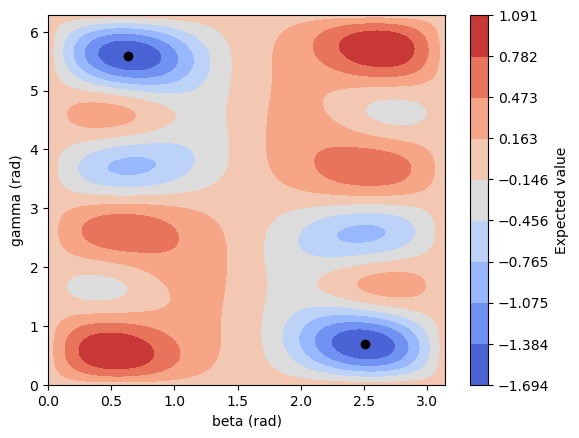

In [30]:
if p==1:
    # Set contour levels
    contour_levels = np.linspace(np.min(Z), np.max(Z), 10)
    X = gamma_range
    Y = beta_range

    # Create a filled contour plot with a color bar
    contour = plt.contourf(Y, X, Z, levels=contour_levels, cmap='coolwarm')
    plt.colorbar(contour, label='Expected value')

    # Add contour lines
    # contour_lines = plt.contour(Y, X, Z, levels=contour_levels, colors='black',
                                # linewidths=0.2, linestyles='solid')

    plt.xlabel('beta (rad)')
    plt.ylabel('gamma (rad)')

    plt.scatter( [beta_range[gam_bet[1][0]]], [gamma_range[gam_bet[0][0]]], color='black')
    plt.scatter([beta_range[gam_bet[1][1]]], [gamma_range[gam_bet[0][1]]], color='black')


    
    plt.show()

I can also check the minimum value with a numerical method, this case is with conjugate gradient, for the case of p=1 I am not taking in account this, but I used just to compare and see the difference with a finite array that I give to gamma and beta, and a numerical method. 

In [31]:
if p==1:
    beta = np.random.rand(p)*np.pi
    gamma = np.random.rand(p)*2*np.pi
    x0 = [gamma[0], beta[0]]
    bounds = [(0, 2*np.pi), (0,np.pi)]
    # Define the constraint
    print(x0)
    res = minimize(f_expectation,
                        x0,
                        method='CG', bounds=bounds)
    print(res)

[0.9588027023732955, 2.7612551392757645]
     fun: -1.6949578798931064
     jac: array([4.47034836e-08, 1.49011612e-08])
 message: 'Optimization terminated successfully.'
    nfev: 39
     nit: 6
    njev: 13
  status: 0
 success: True
       x: array([0.68145124, 2.50502305])


Printing the values of that numerical method and the satte that I can obtain with the values of that method

In [32]:
if p==1:
    print(res.x)
    data_ang = res.x
    print(f_expectation(data_ang))
    print(circ([data_ang[0]], [data_ang[1]]))

[0.68145124 2.50502305]
-1.6949578798931064
Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[ 0.18067226-0.16414484j]
 [-0.13089996-0.34491304j]
 [ 0.41545387-0.64487058j]
 [ 0.17091653-0.22338582j]
 [-0.19979102-0.21276129j]
 [-0.14850962-0.12428011j]
 [-0.02496882+0.00264333j]
 [ 0.09472564-0.06672848j]]


# f)
Creating the function to obtain the succes probability $|<z_0 z_1 z_2| \gamma^*, \beta^*> |^2$

In [33]:
def probs(gamma, beta):
    psi_s = circ(gamma, beta)                       # |gamma, beta> 
    z_st  = zzz.dag()                               # <z_0 z_1 z_2|
    pr = z_st.overlap(psi_s)                        # <z_0 z_1 z_2|gamma, beta>
    pr2 = np.conj(pr)                              
    return np.real(pr*pr2)                         


Calculating the succes probability of the 2 minimum values

In [34]:
if p==1:
    for jj in range(2):
        # data_ang = res.x
        # prob1 = probs([data_ang[0]], [data_ang[1]])
        prob1 = probs([g_p1[jj]], [b_p1[jj]])
        print("minimum  number:", jj+1, " succes probability:" ,prob1)

minimum  number: 1  succes probability: 0.5899899371885012
minimum  number: 2  succes probability: 0.5899899371885008


Calculating the values for the 2D plot of the succes probabilities as a function of $\gamma$ and $\beta$

In [35]:
if p==1:

    Z2 = np.zeros((len(gamma_range), len(beta_range)))

    for i, x in enumerate(gamma_range):         #similar than the last plot values
        # print(x)
        for j, y in enumerate(beta_range):
            l = [x,y]
            Z2[i, j] = probs([x],[y])

# g) Succes probability
Plotting the succes probability

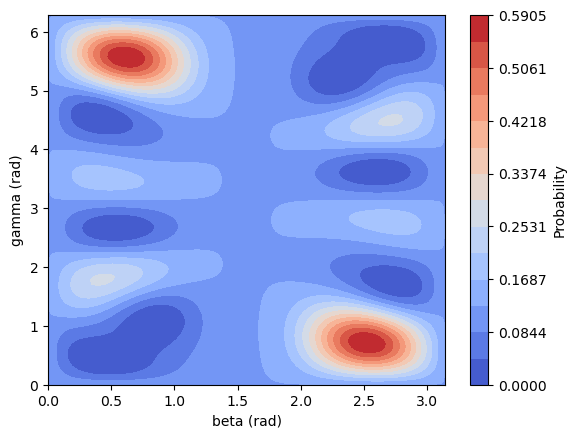

In [36]:
if p==1:
    # Set contour levels
    contour_levels2 = np.linspace(np.min(Z2), np.max(Z2), 15)
    X2 = gamma_range
    Y2 = beta_range

    # Create a filled contour plot with a color bar
    contour2 = plt.contourf(Y2, X2, Z2, levels=contour_levels2, cmap='coolwarm')
    plt.colorbar(contour2, label='Probability')

    # Add contour lines
    # contour_lines2 = plt.contour(X2, Y2, Z2, levels=contour_levels, colors='black', linewidths=0.2, linestyles='solid')

    # Add labels and title
    plt.xlabel('beta (rad)')
    plt.ylabel('gamma (rad)')
    
    
    plt.show()

Searching for the 2 max values with a treshold, and the extracting the values of $\gamma$ and $\beta$

In [37]:
if p==1:
    # Find all points where Z is larger than the treshold
    g_p2 = []
    b_p2 = []
    threshold = 0.59
    # max_indices = np.where(Z2 > threshold)
    Z_val = Z2
    indices2 = Z_val[Z_val> threshold]
    gam_bet2 = np.nonzero(Z_val>threshold)
    print(indices2)
    print(gam_bet2)

    for i in range(len(indices2)):
        print("Max number:",i)
        print("Probability: ", indices2[i])
        g2 = gamma_range[gam_bet2[0][i]]
        b2 = beta_range[gam_bet2[1][i]]
        g_p2.append(g2)
        b_p2.append(b2)
        print("gamma: ", g2)
        print("beta: ", b2)
        print("Probability, this si to double check",probs([g2],[b2]))

[0.5904891 0.5904891]
(array([11, 88]), array([80, 19]))
Max number: 0
Probability:  0.5904890993043574
gamma:  0.6981317007977318
beta:  2.53866073017357
Probability, this si to double check 0.5904890993043574
Max number: 1
Probability:  0.5904890993043571
gamma:  5.585053606381854
beta:  0.6029319234162229
Probability, this si to double check 0.5904890993043571


Just to put the 2 max points in the 2D plot

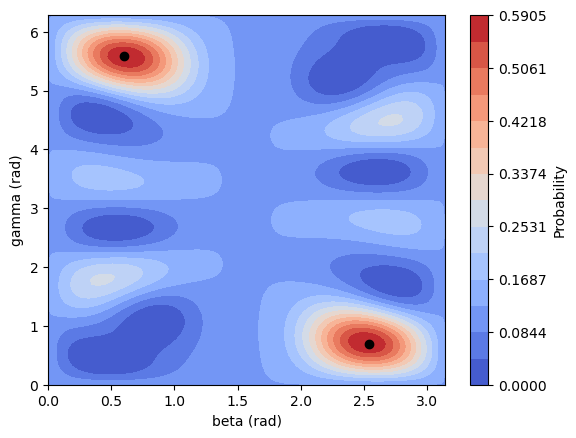

In [38]:
if p==1:
    # Set contour levels
    contour_levels2 = np.linspace(np.min(Z2), np.max(Z2), 15)
    X2 = gamma_range
    Y2 = beta_range

    # Create a filled contour plot with a color bar
    contour2 = plt.contourf(Y2, X2, Z2, levels=contour_levels2, cmap='coolwarm')
    plt.colorbar(contour2, label='Probability')

    # Add contour lines
    # contour_lines2 = plt.contour(X2, Y2, Z2, levels=contour_levels, colors='black', linewidths=0.2, linestyles='solid')

    # Add labels and title
    plt.xlabel('beta (rad)')
    plt.ylabel('gamma (rad)')
    
    plt.scatter( [beta_range[gam_bet2[1][0]]], [gamma_range[gam_bet2[0][0]]], color='black')
    plt.scatter([beta_range[gam_bet2[1][1]]], [gamma_range[gam_bet2[0][1]]], color='black')

    
    plt.show()

# h) Comparing

In [39]:
if p==1:
    for i in range(2):
        deltag = np.abs(gamma_range[gam_bet2[0][i]] - gamma_range[gam_bet[0][i]])
        deltab = np.abs(gamma_range[gam_bet2[1][i]] - gamma_range[gam_bet[1][i]])

        
        print("numer of the min/max:",i+1)
        # print(gamma_range[gam_bet2[0][i]])
        # print(gamma_range[gam_bet[0][i]])
        print("Delta gamma: ", deltag)
        print("Delta beta: ", deltab)
    

numer of the min/max: 1
Delta gamma:  0.0
Delta beta:  0.06346651825433902
numer of the min/max: 2
Delta gamma:  0.0
Delta beta:  0.06346651825433924


# 3: p =2

For this case I am going to minimize with numerical methods, because plotting can take a lot of time and resources. So I am going to use the technique of Conjugate Gradient (CG) and the Broyden-Fletcher-Goldfarb-Shanno (BFGS). In both cases I will just save if the final result is inside our boundaries ($\gamma \in [0,2*\pi)$ and $\beta \in [0,\pi)$ ). 

In [62]:
if p==2:
    fun1 = []    # to save the values
    ang_g_b = []
    for i in range(100):    # 100 times to arrive to the "global min values", taking the best 
        beta = np.random.rand(p)*np.pi
        gamma = np.random.rand(p)*2*np.pi
        x0 = [gamma[0], gamma[1], beta[0], beta[1]]
        bounds = [(0, 2*np.pi), (0, 2*np.pi), (0, np.pi),(0,np.pi)] #boundary
        # Define the constraint
        # print(x0)
        res = minimize(f_expectation,
                            x0,
                            method='CG', bounds=bounds)
        # print(res)  
        # the if is for the boundaries that I want and also for the treshold value
        #the boundary is the values that can be gamma and beta
        if res.fun<-2.7 and 0<=res.x[0]<=2*np.pi and 0<=res.x[1]<=2*np.pi and 0<=res.x[2]<=np.pi and 0<=res.x[3]<=np.pi   :
            fun1.append(res.fun)
            ang_g_b.append(res.x)

/home/mstorresh/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/home/mstorresh/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/home/mstorresh/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/home/mstorresh/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/home/mstorresh/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method CG cannot handle c

This is to eliminate the repeated values

In [63]:
if p==2:
    print("print the original list of min values",fun1) 
    print("print the original list of min values angles",ang_g_b)
    
    # Crear un diccionario auxiliar para rastrear elementos únicos 
    aux_dict = {}
    fun1_no_dup = []
    ang_g_b_no_dup = []

    for a, b in zip(fun1, ang_g_b):
        if a not in aux_dict:
            aux_dict[a] = b
            fun1_no_dup.append(a)
            ang_g_b_no_dup.append(b)
    print("min value: ",np.min(fun1))
    print("number of min values:",len(fun1))
    print("list of the min values:",fun1_no_dup)
    print("list of the angles of those values:",ang_g_b_no_dup)

print the original list of min values [-2.7205684471408653, -2.720568447137854, -2.72056844714124]
print the original list of min values angles [array([0.45320432, 0.73177881, 2.32867645, 2.65112233]), array([5.82998142, 5.55140743, 0.81291629, 0.4904704 ]), array([0.45320426, 0.73177838, 2.32867662, 2.6511223 ])]
min value:  -2.72056844714124
number of min values: 3
list of the min values: [-2.7205684471408653, -2.720568447137854, -2.72056844714124]
list of the angles of those values: [array([0.45320432, 0.73177881, 2.32867645, 2.65112233]), array([5.82998142, 5.55140743, 0.81291629, 0.4904704 ]), array([0.45320426, 0.73177838, 2.32867662, 2.6511223 ])]


The same that the last 2 code boxes, but with BFGS

For this case I am going to minimize with numerical methods, because plotting can take a lot of time and resources. So I am going to use the technique of the Broyden-Fletcher-Goldfarb-Shanno (BFGS).  I will just save if the final result is inside our boundaries ($\gamma \in [0,2*\pi)$ and $\beta \in [0,\pi)$ ). 

In [66]:
if p==2:
    fun2 = []       # to save the values
    ang_g_b2 = []
    for i in range(100):     # 100 times to arrive to the "global min values", taking the best
        beta = np.random.rand(p)*np.pi
        gamma = np.random.rand(p)*2*np.pi
        x0 = [gamma[0], gamma[1], beta[0], beta[1]]
        bounds = [(0, 2*np.pi), (0, 2*np.pi), (0, np.pi),(0,np.pi)]
        # Define the constraint
        # print(x0)
        res = minimize(f_expectation,
                            x0,
                            method='BFGS', bounds=bounds)
        # print(res)
        # the if is for the boundaries that I want and also for the treshold value
        #the boundary is the values that can be gamma and beta
        if res.fun<-2.7 and 0<=res.x[0]<=2*np.pi and 0<=res.x[1]<=2*np.pi and 0<=res.x[2]<=np.pi and 0<=res.x[3]<=np.pi   :
            fun2.append(res.fun)
            ang_g_b2.append(res.x)

This is to eliminate the repeated values

In [67]:

if p==2:
    print(fun2)
    print(ang_g_b2)
    
    # Crear un diccionario auxiliar para rastrear elementos únicos 
    aux_dict = {}
    fun1_no_dup2 = []
    ang_g_b_no_dup2 = []

    for a, b in zip(fun2, ang_g_b2):
        if a not in aux_dict:
            aux_dict[a] = b
            fun1_no_dup2.append(a)
            ang_g_b_no_dup2.append(b)
    print("min value: ",np.min(fun2))
    print("number of min values:",len(fun2))
    print("list of the min values:",fun1_no_dup2)
    print("list of the angles of those values:",ang_g_b_no_dup2)

[-2.7205684471416984, -2.72056844714123, -2.720568447141654]
[array([5.82998126, 5.55140677, 0.81291608, 0.49047035]), array([0.45320383, 0.73177856, 2.32867655, 2.65112235]), array([5.8299812 , 5.55140672, 0.81291607, 0.49047042])]
min value:  -2.7205684471416984
number of min values: 3
list of the min values: [-2.7205684471416984, -2.72056844714123, -2.720568447141654]
list of the angles of those values: [array([5.82998126, 5.55140677, 0.81291608, 0.49047035]), array([0.45320383, 0.73177856, 2.32867655, 2.65112235]), array([5.8299812 , 5.55140672, 0.81291607, 0.49047042])]


In [68]:
if p==2:
    print("CG min list values:",fun1_no_dup)
    print("CG min list angles:",ang_g_b_no_dup)
    print("BFGS min list values:",fun1_no_dup2)
    print("BFGS min list angles:",ang_g_b_no_dup2)

CG min list values: [-2.7205684471408653, -2.720568447137854, -2.72056844714124]
CG min list angles: [array([0.45320432, 0.73177881, 2.32867645, 2.65112233]), array([5.82998142, 5.55140743, 0.81291629, 0.4904704 ]), array([0.45320426, 0.73177838, 2.32867662, 2.6511223 ])]
BFGS min list values: [-2.7205684471416984, -2.72056844714123, -2.720568447141654]
BFGS min list angles: [array([5.82998126, 5.55140677, 0.81291608, 0.49047035]), array([0.45320383, 0.73177856, 2.32867655, 2.65112235]), array([5.8299812 , 5.55140672, 0.81291607, 0.49047042])]


In [69]:
if p==2:
    list_angles = [list(a) for a in ang_g_b_no_dup2]
    for ii in range(p):
        gam_l = list_angles[ii][:p]
        bet_l = list_angles[ii][p:]
        print(ii+1,") gamma optimal:",gam_l)
        print(" beta optimal:",bet_l)
        proba_4ang = probs(gam_l, bet_l)
        print(" succes probability:",proba_4ang)
        l1 = gam_l + bet_l
        # l1.append(bet_l)
        # print(l1)
        energy_4ang = f_expectation(l1)
        print(" minimum energy value: ", energy_4ang)

1 ) gamma optimal: [5.829981258906324, 5.551406768129192]
 beta optimal: [0.812916083580349, 0.4904703502300246]
 succes probability: 0.8913633556392728
 minimum energy value:  -2.7205684471416984
2 ) gamma optimal: [0.453203830463551, 0.7317785607267699]
 beta optimal: [2.3286765461328174, 2.6511223514335667]
 succes probability: 0.8913633444593896
 minimum energy value:  -2.72056844714123
